In [4]:
seed = 0

In [5]:
from utilities.load_data import load_fullECAI
from utilities.evaluation import *
from utilities import model_utils

In [6]:
from time import time
import joblib
import os
import numpy as np
import pandas as pd
import shap
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier, Booster, DMatrix

In [57]:
# define models to test

def get_models():
    models, names = list(), list()
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
    f1_scorer = make_scorer(f1_score)
    
    # LR
    param_grid = {"C": [1000, 200, 100, 50, 10, 1, .1],
                  "penalty": ["l1", "l2"]}
    model = LogisticRegression(max_iter=3000, solver='liblinear')
    model = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=f1_scorer)
    models.append(model)
    names.append('LR')
    
    # LR
    model = LogisticRegression(max_iter=10000)
    models.append(model)
    names.append('LR')
    
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    
    # RF
    param_grid = {'max_depth': [10, 50, 70, 100, None],
                  'min_samples_leaf': [1, 2, 4],
                  'min_samples_split': [2, 5, 10],
                  'n_estimators': [100, 200, 500, 800]}
    
    model = RandomForestClassifier()
    model = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=f1_scorer)
    models.append(model)
    names.append('RF')
    
    # XGB
    models.append(XGBClassifier(use_label_encoder=False))
    names.append('XGB')
    return models, names

In [8]:
from sklearn.pipeline import Pipeline

class SaveModelInfo():
    def __init__(self, clf, X_val, y_val, folder_path='results/Basic1/models'):
        # clf
        if type(clf) == Pipeline:
            if type(clf.named_steps['m']) == GridSearchCV:
                self.model = clf.named_steps['m'].best_estimator_
            else:
                self.model = clf.named_steps['m']
        else:
            if type(clf) == GridSearchCV:
                self.model = clf.best_estimator_
            else:
                self.model = clf
        
        # X_val
        if type(clf) == Pipeline:
            self.X_val = pd.DataFrame(clf.named_steps['nr'].transform(X_val), 
                                      columns=X_val.columns, 
                                      index=X_val.index)
        else:
            self.X_val = X_val
            
        self.y_val = y_val
        self.folder_path = folder_path
    
    def save_model(self):
        self.get_info()
        to_save = {'params': self.params,
                   'shap_test': self.shap_test,
                   'shap_df': self.shap_df,
                   'val_idx': self.X_val.index.values, 
                   'y_pred': self.y_pred,
                   'y_proba': self.y_proba,
                   'confusion_matrix': self.cf, 
                   'f1': self.f1}
        
        model_name = type(self.model).__name__ + '.pkl'
        if not os.path.exists(self.folder_path):
            os.makedirs(self.folder_path)
        model_savepath = '{}/{}'.format(self.folder_path, model_name)
        
        joblib.dump(to_save, model_savepath)
        
    def get_info(self):
        self.params = self.model.get_params()
        self.shap_test, self.shap_df = self.get_shap()
        self.y_pred = self.model.predict(self.X_val)
        self.y_proba = self.model.predict_proba(self.X_val)
        self.cf = confusion_matrix(self.y_val, self.y_pred)
        self.f1 = f1_score(self.y_val, self.y_pred)
        
    def get_shap(self):
        if type(self.model).__name__ == 'RandomForestClassifier':
            explainer = shap.TreeExplainer(self.model, self.X_val)
            shap_test = explainer(self.X_val, check_additivity=False)[:,:,1]
            shap_df = pd.DataFrame(shap_test.values, 
                                   columns=shap_test.feature_names, 
                                   index=self.X_val.index)
        else:
            explainer = shap.Explainer(self.model, self.X_val)
            shap_test = explainer(self.X_val)    
            shap_df = pd.DataFrame(shap_test.values,
                                   columns=shap_test.feature_names, 
                                   index=self.X_val.index)
        
        return shap_test, shap_df      

In [9]:
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [7]:
def log_metrics_and_explanations(clf, X_val, y_true_val, y_pred_val, y_prob_val):
    cf = confusion_matrix(y_true_val, y_pred_val)
    f1 = f1_score(y_true_val, y_pred_val)
    
    if type(clf.named_steps['m']) == GridSearchCV:
        model = clf.named_steps['m'].best_estimator_
    else:
        model = clf.named_steps['m']
        
    X_trans = pd.DataFrame(clf.named_steps['nr'].transform(X_val), columns=X_val.columns)
    if type(model).__name__ == 'RandomForestClassifier':
        explainer = shap.TreeExplainer(model, X_trans)
        shap_test = explainer(X_trans, check_additivity=False)[:,:,1]
        shap_df = pd.DataFrame(shap_test.values, 
                               columns=shap_test.feature_names, 
                               index=X_val.index)
    else:
        explainer = shap.Explainer(model, X_trans)
        shap_test = explainer(X_trans)    
        shap_df = pd.DataFrame(shap_test.values,
                               columns=shap_test.feature_names, 
                               index=X_val.index)
    ### Save to file
    timestring = "".join(str(time()).split("."))
    model_name = type(model).__name__ + '.pkl'
    
    if not os.path.exists('results/Basic1/models'):
        os.makedirs('results/Basic1/models')
    model_savepath = 'results/Basic1/models/{}'.format(model_name)

    model_utils.save_model(model_savepath, 
                           clf.get_params(), 
                           shap_test, 
                           shap_df, 
                           X_val, 
                           y_pred_val, 
                           y_prob_val, 
                           cf, 
                           f1)
    
    return f1

def _my_scorer(clf, X_val, y_true_val):
    # do all the work and return some of the metrics
    y_pred_val = clf.predict(X_val)
    y_prob_val = clf.predict_proba(X_val)
    f1 = log_metrics_and_explanations(clf, X_val, y_true_val, y_pred_val, y_prob_val)
    
    return f1

## Validación cruzada

In [31]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for model in models:
    # define model to evaluate
    norm = Normalizer()
    # scale, then undersample, then fit model
    pipeline = Pipeline(steps=[('nr',norm), ('m',model)])
    # evaluate the model and store results
    print(model)
    if type(model) == GridSearchCV:
        pipeline.fit(X_train, y_train)
        grid = pipeline.named_steps['m']
        grid_df = pd.DataFrame(grid.cv_results_)
        filter_col = [col for col in grid_df if col.startswith('split')]
        scores = grid_df[grid_df.mean_test_score == grid_df.mean_test_score.max()][filter_col].values.reshape((15,))
    else:    
        scores = evaluate_model(X_train, y_train, pipeline, make_scorer(f1_score))
    results.append(scores)
results = np.array(results).T
results = pd.DataFrame(results, columns=names)
sorted_index = results.mean().sort_values().index
results = results[sorted_index]

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=0),
             estimator=LogisticRegression(max_iter=3000, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': [10, 1, 0.1, 0.05, 0.01, 0.001],
                         'penalty': ['l1', 'l2']},
             scoring=make_scorer(f1_score))
LinearDiscriminantAnalysis()
min: 0.21556886227544908
max: 0.28650137741046827
mean: 0.24321001347944102
GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=0),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 500, 800]},
             scoring=make_scorer(f1_score))
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta

/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/azaelcarrillo/miniconda3/envs/XAI_credit/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas

min: 0.38541666666666663
max: 0.5025125628140703
mean: 0.4568635204666252
[19:28:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:28:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:28:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:28:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to

## Guardar resultados y valores SHAP

In [58]:
models, names = get_models()
models_names = list(zip(models, names))
test_f1s = []
for model, name in models_names[0:3]:
    norm = Normalizer()
    # scale, then undersample, then fit model
    pipeline = Pipeline(steps=[('nr',norm), ('m',model)])
    pipeline.fit(X_train, y_train)
    if type(pipeline.named_steps['m']) == GridSearchCV:
        grid = pipeline.named_steps['m']
        joblib.dump(grid, './results/modeling/{}_grid.pkl'.format(name))
    smi = SaveModelInfo(pipeline, X_test, y_test)
    smi.save_model()
    test_f1s.append(smi.f1)

X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
X has feature names, but LinearDiscriminantAnalysis was fitted without feature names


## Graficar resultados

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Solo para poder cargar el objeto gridsearch
def _my_scorer():
    return None

In [32]:
# Cargar modelos adicionales
import joblib
# Giudici
results['GIU'] = joblib.load('./results/giudici_scores.pkl')

# Opti
grid = joblib.load('./results/XGBoost/GridSearchCV_22-03-22_03-27-03/GridSearchCV_22-03-22_03-27-03.pkl')
grid_df = pd.DataFrame(grid.cv_results_)
filter_col = [col for col in grid_df if col.startswith('split')]
results['XGBB'] = grid_df[grid_df.mean_test_score == grid_df.mean_test_score.max()][filter_col].values.reshape((15,))

### CV scores

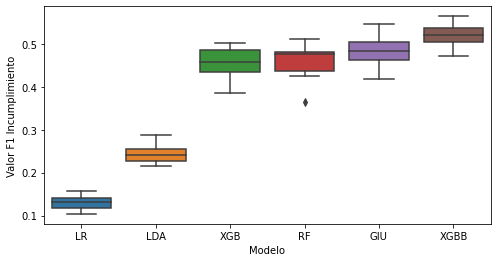

In [33]:
sns.boxplot(x="variable", y="value", data=pd.melt(results))
if not os.path.exists('figures/modeling_basic'):
    os.makedirs('figures/modeling_basic')
plt.ylabel('Valor F1 Incumplimiento')
plt.xlabel('Modelo')
fig = plt.gcf()
fig.set_size_inches(8,4)
fig.savefig('results/figures/modeling_basic/mb_F1_CV.png', bbox_inches='tight', dpi=300, transparent=True)
fig.savefig('results/figures/modeling_basic/mb_F1_CV.svg', bbox_inches='tight', transparent=True)

### Métricas en test

In [36]:
from sklearn.metrics import accuracy_score

In [39]:
models_paths = ['./results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb.pkl', 
                './results/Basic1/models/RandomForestClassifier.pkl',
                './results/Basic1/models/XGBClassifier.pkl',
                './results/Basic1/models/LogisticRegression.pkl',
                './results/Basic1/models/LinearDiscriminantAnalysis.pkl']

metricas_test = []
for model in models_paths:
    model_folder = '/'.join(model.split('/')[:-1])
    model_name = model.split('/')[-1].split('.')[0]
    model_results = joblib.load(model)
    y_pred = model_results['y_pred']
    y_proba = model_results['y_proba'][:,1]
    
    metricas = {}
    metricas['Modelo'] = model_name
    metricas['F1 1'] = f1_score(y_test, y_pred, average='binary', pos_label=1)
    metricas['F1 0'] = f1_score(y_test, y_pred, average='binary', pos_label=0)
    metricas['F1 macro'] = f1_score(y_test, y_pred, average='macro')
    metricas['AUC'] = roc_auc_score(y_test, y_proba)
    metricas['Precisión'] = accuracy_score(y_test, y_pred)
    
    metricas_test.append(metricas)
    
# Llenar metricas giudici a mano (Bussmann2020_replication)
metricas = {}
metricas['Modelo'] = 'Bussman'
metricas['F1 1'] = 0.50
metricas['F1 0'] = 0.9531
metricas['F1 macro'] = 0.7265
metricas['AUC'] = 0.8736
metricas['Precisión'] = 0.9142

metricas_test.append(metricas)

In [40]:
pd.DataFrame(metricas_test)

,Modelo,F1 1,F1 0,F1 macro,AUC,Precisión
0,best_xgb,0.548128,0.935863,0.741996,0.873553,0.887670
1,RandomForestClassifier,0.495868,0.955909,0.725888,0.877861,0.918910
2,XGBClassifier,0.507937,0.955024,0.731480,0.853091,0.917581
3,LogisticRegression,0.154255,0.943637,0.548946,0.768636,0.894317
4,LinearDiscriminantAnalysis,0.245940,0.941829,0.593884,0.774951,0.891991
5,Bussman,0.500000,0.953100,0.726500,0.873600,0.914200


## Remuestreo

In [9]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import InstanceHardnessThreshold

In [10]:
def get_models():
    models, names = list(), list()
    # TL
    models.append(TomekLinks())
    names.append('TL')
    # ENN
    models.append(EditedNearestNeighbours())
    names.append('ENN')
    # RENN
    models.append(RepeatedEditedNearestNeighbours())
    names.append('RENN')
    # NCR
    models.append(NeighbourhoodCleaningRule())
    names.append('NCR')
    # IHT
    models.append(InstanceHardnessThreshold())
    names.append('IHT')
    return models, names

In [ ]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # define model to evaluate
    model = XGBClassifier(use_label_encoder=False)
    # scale, then undersample, then fit model
    pipeline = Pipeline(steps=[('nr',norm), ('s', models[i]), ('m',model)])
    # evaluate the model and store results
    print(models[i])
    scores = evaluate_model(X_train, y_train, pipeline, f1_macro)
    results.append(scores)
results = np.array(results).T
results = pd.DataFrame(results, columns=names)
sorted_index = results.mean().sort_values().index
results = results[sorted_index]
results['GIU'] = joblib.load('giudici_scores.pkl')

TomekLinks()
min: 0.6692156469968927
max: 0.734985223914526
mean: 0.706710337870647
EditedNearestNeighbours()
min: 0.6875234780687217
max: 0.7446709916589435
mean: 0.7168172767263815
RepeatedEditedNearestNeighbours()
min: 0.6596952701859183
max: 0.7218696851352
mean: 0.6942059960708669
OneSidedSelection()


C:\Users\azael\miniconda3\envs\ciencia_datos_nogpu\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\azael\miniconda3\envs\ciencia_datos_nogpu\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\azael\miniconda3\envs\ciencia_datos_nogpu\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\azael\miniconda3\envs\ciencia_datos_nogpu\lib\site-packages\imblearn\pipeline

min: nan
max: nan
mean: nan
NeighbourhoodCleaningRule()


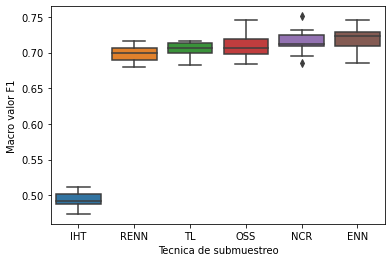

In [13]:
sns.boxplot(x="variable", y="value", data=pd.melt(results))
if not os.path.exists('figures/modeling_basic'):
    os.makedirs('figures/modeling_basic')
plt.ylabel('Macro valor F1')
plt.xlabel('Tecnica de submuestreo')
plt.savefig('figures/modeling_basic/mb_subsample.png', bbox_inches='tight', dpi=300, transparent=True)

In [45]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # define model to evaluate
    model = RandomForestClassifier()
    # scale, then undersample, then fit model
    pipeline = Pipeline(steps=[('nr',norm), ('s', models[i]), ('m',model)])
    # evaluate the model and store results
    print(models[i])
    evaluate_model(X_train, y_train, pipeline, f1_macro)

TomekLinks()
min: 0.6812854191050038
max: 0.7293561923308759
mean: 0.7081888635843062
EditedNearestNeighbours()
min: 0.7000215265739891
max: 0.7437260988424574
mean: 0.7249927388509014
RepeatedEditedNearestNeighbours()
min: 0.6913181622602478
max: 0.7152153336488405
mean: 0.7038746760261354
OneSidedSelection()
min: 0.6766241594167114
max: 0.7346257206514
mean: 0.7071219612210558
NeighbourhoodCleaningRule()
min: 0.684745794768136
max: 0.7470828359460056
mean: 0.7199188261331855
InstanceHardnessThreshold()
min: 0.472813758834455
max: 0.4938446193816107
mean: 0.4856295232665266


In [38]:
model = XGBClassifier(use_label_encoder=False)
# scale, then undersample, then fit model
pipeline = Pipeline(steps=[('nr',norm), ('s', models[1]), ('m',model)])
pipeline.fit(X_train, y_train)

[04:28:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('nr', Normalizer()), ('s', EditedNearestNeighbours()),
                ('m',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               vali

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

In [41]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2683
           1       0.58      0.55      0.56       326

    accuracy                           0.91      3009
   macro avg       0.76      0.75      0.75      3009
weighted avg       0.91      0.91      0.91      3009



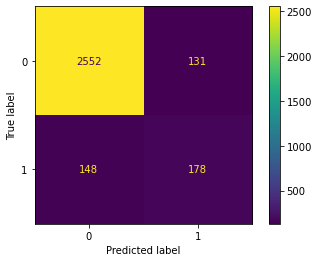

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [54]:
f1_scorer(grid, X_test, y_test)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


0.5481283422459893

In [58]:
from sklearn.metrics import roc_auc_score

In [56]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      2683
           1       0.49      0.63      0.55       326

    accuracy                           0.89      3009
   macro avg       0.72      0.77      0.74      3009
weighted avg       0.90      0.89      0.89      3009



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [ ]:
y_pred = grid.predict_proba(X_test)
roc_auc_score()